In [1]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Using TensorFlow backend.


In [43]:
df = pd.read_csv('./RNN_data_Fraiser.csv', parse_dates={'dt' : ['Unnamed: 0']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'])
#, index_col='Unnamed: 0'         , parse_dates={'Unnamed: 0' : ['Date', 'Time']}

df.index = pd.to_datetime(df.dt)

In [44]:
df.head() 

,dt,NumTrips
dt,,
2016-01-01 00:00:00,2016-01-01 00:00:00,93
2016-01-01 01:00:00,2016-01-01 01:00:00,106
2016-01-01 02:00:00,2016-01-01 02:00:00,117
2016-01-01 03:00:00,2016-01-01 03:00:00,107
2016-01-01 04:00:00,2016-01-01 04:00:00,72


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2016-01-01 00:00:00 to 2016-12-31 00:00:00
Data columns (total 2 columns):
dt          8761 non-null datetime64[ns]
NumTrips    8761 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 205.3 KB


In [46]:
df.dtypes

dt          datetime64[ns]
NumTrips             int64
dtype: object

In [47]:
df.shape

(8761, 2)

In [48]:
df.describe()

,NumTrips
count,8761.000000
mean,76.897386
std,56.191643
min,0.000000
25%,28.000000
50%,73.000000
75%,113.000000
max,308.000000


In [49]:
df.columns

Index(['dt', 'NumTrips'], dtype='object')

In [50]:
## finding all columns that have nan:

droping_list_all=[]
for j in range(0,1):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[]

In [51]:
# another sanity check to make sure that there are not more any nan
df.isnull().sum()

dt          0
NumTrips    0
dtype: int64

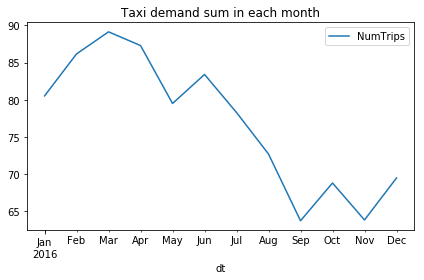

In [54]:
df.resample('M').mean().plot(title='Taxi demand sum in each month') 
plt.tight_layout()
plt.show() 

In [53]:
df.mean()

NumTrips    76.897386
dtype: float64

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7*24, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[169:], axis=1, inplace=True)
print(reframed.head())

In [ ]:
reframed.shape

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = int(reframed.shape[0]/2)
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],  test_X.shape[1], 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].


model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#history = model.fit(train_X, train_y, epochs=20, batch_size=70, verbose=2, shuffle=False)


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()



In [ ]:
# make a prediction
test_X = test_X.reshape((test_X.shape[0], 168, 1))
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 168))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -167:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -167:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 
plt.figure(figsize=(20, 5))
aa=[x for x in range(1000)]
plt.plot(aa, inv_y[:1000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:1000], 'r', label="prediction")
plt.ylabel('Number of Pickups', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()